In [91]:
import requests
from tqdm import tqdm
import pandas as pd
# from owlready2 import get_ontology
import os

from modul.standardization_usingsparql import addTaxonColumn, buat_kolom_taxon_awal
from modul.disambiguation_optimized import buat_kamus_kosong, update_kamus_pake_wikidata, update_df_pake_kamus, update_df_pake_path_ujung, removeOtherThanNCBI
from modul.preprocess import cleaning, splitInteractionToNodeEdge
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,takeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean
from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string

In [92]:
data_init=[
    ('begomovirus_contoh_hasil','Pepper yellow leaf curl virus','Aleyrodidae','Bemisia Tabaci'),
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

In [93]:
#1 inisiasi
ini_data=data_init[0]
#parameter
nama_file = ini_data[0]
virus_txt = ini_data[1].replace(' ','%20')
tipe_interaksi_virus = 'hasHost' #pathogenOf, pake relasi hasHost lebih dapat banyak relasi dari pada pathogenOf
tipe_interaksi_tanaman = 'hostOf' #hasPathogen, pake relasi hostOf lebih dapat banyak relasi dari pada hasPathogen
tipe_interaksi_serangga_ke_tanaman = 'hasHost' 
tipe_interaksi_serangga_ke_virus = 'hostOf' 
ncbi_server_url = 'http://localhost:3030/mydataset/query'

In [94]:
virus_search = get_taxon_vector(virus_txt,ncbi_server_url)
if (virus_search==False):
    virus_search=[('unknown',virus_txt)]
virus_search

[('spesies', 'NCBI:881944_Pepper yellow leaf curl virus'),
 ('genus', 'NCBI:10814_Begomovirus'),
 ('famili', 'NCBI:10811_Geminiviridae'),
 ('ordo', 'NCBI:2732539_Geplafuvirales'),
 ('kelas', 'NCBI:2732424_Repensiviricetes'),
 ('filum', 'NCBI:2732416_Cressdnaviricota'),
 ('kingdom', 'NCBI:2732092_Shotokuvirae'),
 ('superkingdom', 'NCBI:10239_Viruses')]

In [95]:
#2 ambil data dari globi
kolom=[
    'source_taxon_external_id',
    'source_taxon_name',
    'source_taxon_path',
    'source_taxon_path_ids',
    'source_taxon_path_ranks',
    
    'interaction_type',
    
    'target_taxon_external_id',
    'target_taxon_name',
    'target_taxon_path',
    'target_taxon_path_ids',
    'target_taxon_path_ranks',
]

interactionType=tipe_interaksi_virus
print('layer 1 pertama',virus_search[0][1].split('_'))
link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+virus_search[0][1].split('_')[0]+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
response = requests.get(link)
res=response.json()
if not res['data']:
    print('stop kosong')
# JSON To Pandas Dataframe
df = pd.json_normalize(res, record_path =['data'])

if(len(virus_search) == 1):
    pass
elif(virus_search[1][0] not in ['famili','genus']):
    pass
else:
    print('layer 1 kedua',virus_search[1][1].split('_')) # yg kedua dari famili atau genusnya.
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+virus_search[1][1].split('_')[0]+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    if not res['data']:
        print('kosong')
    # JSON To Pandas Dataframe
    df_ = pd.json_normalize(res, record_path =['data'])
    df=pd.concat([df,df_])

df.columns = kolom

layer 1 pertama ['NCBI:881944', 'Pepper yellow leaf curl virus']
layer 1 kedua ['NCBI:10814', 'Begomovirus']


In [96]:
#3 splitting layer 1 interaksi virus
df_node, df_edge = splitInteractionToNodeEdge(df)

In [97]:
len(df_node),len(df_edge)

(516, 514)

In [98]:
#4 cleaning_after_get layer 1 interaksi virus
df_node.drop_duplicates(inplace=True)
#
no_ncbi_and_path_null=(df_node.taxon_id.str.contains('NCBI')==False) & (df_node.taxon_path_ids.isnull())
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[no_ncbi_and_path_null], df_node,df_edge) 
#
df_edge.drop_duplicates(inplace=True)

removeNodeAndEdgeByFilter
sebelum : 516 514
sesudah : 515 513


In [99]:
len(df_node),len(df_edge)

(515, 513)

In [100]:
#4a tandai virus utama
filter_virus_utama=(
    (df_node.taxon_name.str.contains('virus',case=False))
    | (df_node.taxon_path.str.contains('virus', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
# df_node.loc[filter_virus_utama, ['virus_utama']] = True
virus_utama=[data.taxon_id for idx,data in df_node[filter_virus_utama].iterrows()]

In [101]:
#5 disambiguasi layer 1 interaksi virus
kamus_ncbi = buat_kamus_kosong(df_node)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
df_node,df_edge = update_df_pake_kamus(kamus_ncbi,df_node,df_edge)
df_node,df_edge = update_df_pake_path_ujung(df_node,df_edge)
#tambah kolom takson pake data NCBI
df_node = buat_kolom_taxon_awal(df_node) #buat kolom taxon, default none
df_node = addTaxonColumn(df_node,'http://localhost:3030/mydataset/query') # isi pake ncbi

['GBIF', 'EOL', 'EOL_V2'] 3  database,  3  kali perulangan akses NCBI
GBIF : jumlah id 56


100%|██████████| 49/49 [00:00<00:00, 216794.19it/s]


EOL : jumlah id 99


100%|██████████| 92/92 [00:00<00:00, 218998.85it/s]


EOL_V2 : jumlah id 22


100%|██████████| 5/5 [00:00<00:00, 15011.83it/s]


In [102]:
#untuk laporan
#kode database
print(kamus_ncbi.keys())

key=[]
val=[]
for i in kamus_ncbi:
    key.extend(list(kamus_ncbi[i].keys()))
    val.extend(list(kamus_ncbi[i].values()))
    
df_kamus=pd.DataFrame({'key':key,'val':val})

# csv
# df_kamus.to_csv('output.xlsx', index=False)

# semua 
# df_kamus
# yang kosong
len(df_kamus[(df_kamus.val != '')])

dict_keys(['GBIF', 'EOL', 'EOL_V2'])


143

In [103]:
# cleaning_after_disambiguasi layer 1
df_node, df_edge = removeOtherThanNCBI(df_node,df_edge)# Hapus kalo masih ada selain NCBI
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus edge yang tidak ada nodenya
filter_kingdom_atau_class_null=( (df_node.kingdom.isnull()) | (df_node['class'].isnull()) )
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_kingdom_atau_class_null], df_node,df_edge)

removeOtherThanNCBI
sebelum : 515 513
sesudah : 515 513
removeEdgesNotInNodes
sebelum :  513
sesudah :  513
removeNodeAndEdgeByFilter
sebelum : 515 513
sesudah : 514 511


In [104]:
#7 pengambilan interaksi tanaman
df_to_add=pd.DataFrame(columns = kolom)
df_plant=df_node[df_node.kingdom=='NCBI:33090_Viridiplantae']
interactionType=tipe_interaksi_tanaman
for idx,i in tqdm(df_plant.iterrows(), total=df_plant.shape[0]):
    search=i.taxon_name.replace(' ','%20')
    # print('depth 2 tanaman :', search)
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+search+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    # JSON To Pandas Dataframe
    temp_to_add=pd.json_normalize(res, record_path =['data'])
    temp_to_add.columns = kolom
    # add to sebelumnya
    df_to_add = pd.concat([
        df_to_add,
        temp_to_add
    ], ignore_index = True)

100%|██████████| 197/197 [03:39<00:00,  1.11s/it]


In [105]:
# 7 pengambilan interaksi serangga -> tanaman
df_insect = df_node[df_node['class']=='NCBI:50557_Insecta']
interactionType = tipe_interaksi_serangga_ke_tanaman
for idx,i in tqdm(df_insect.iterrows(), total=df_insect.shape[0]):
    search=i.taxon_name.replace(' ','%20')
    # print('depth 2 tanaman :', search)
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+search+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    # JSON To Pandas Dataframe
    temp_to_add=pd.json_normalize(res, record_path =['data'])
    temp_to_add.columns = kolom
    # add to sebelumnya
    df_to_add = pd.concat([
        df_to_add,
        temp_to_add
    ], ignore_index = True)


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


In [106]:
# 7 pengambilan interaksi serangga -> virus
df_insect = df_node[df_node['class']=='NCBI:50557_Insecta']
interactionType = tipe_interaksi_serangga_ke_virus
for idx,i in tqdm(df_insect.iterrows(), total=df_insect.shape[0]):
    search=i.taxon_name.replace(' ','%20')
    # print('depth 2 tanaman :', search)
    link="https://api.globalbioticinteractions.org/interaction?sourceTaxon="+search+"&interactionType="+interactionType+"&fields="+(','.join(kolom))
    response = requests.get(link)
    res=response.json()
    # JSON To Pandas Dataframe
    temp_to_add=pd.json_normalize(res, record_path =['data'])
    temp_to_add.columns = kolom
    # add to sebelumnya
    df_to_add = pd.concat([
        df_to_add,
        temp_to_add
    ], ignore_index = True)

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


In [107]:
#3 splitting depth 2 interaksi serangga dan tanaman
node_to_add, edge_to_add = splitInteractionToNodeEdge(df_to_add)

In [108]:
# hapus edge inverse
kebalikan={
    'hostOf':'hasHost',
    'hasPathogen':'pathogenOf', 
    'pollinatedBy':'pollinates', 
    'flowersVisitedBy':'visitFlowersOf',
    'visitedBy':'visit'
}
for i,data in  edge_to_add[edge_to_add['interaction_type'].isin([
    'hostOf', 'hasPathogen', 'pollinatedBy', 'flowersVisitedBy','visitedBy'
    ])].iterrows():
    edge_to_add.iloc[i]['interaction_type']=kebalikan[data['interaction_type']]
    edge_to_add.iloc[i]['source_taxon_id']=data['target_taxon_id']
    edge_to_add.iloc[i]['target_taxon_id']=data['source_taxon_id']

In [109]:
#4 cleaning_after_get depth 2 interaksi serangga dan tanaman
print('node_to_add.drop_duplicates')
node_to_add.drop_duplicates(inplace=True)
print(len(node_to_add),len(edge_to_add))
#
no_ncbi_and_path_null=(node_to_add.taxon_id.str.contains('NCBI')==False) & (node_to_add.taxon_path_ids.isnull())
node_to_add,edge_to_add = removeNodeAndEdgeByFilter(node_to_add[no_ncbi_and_path_null], node_to_add,edge_to_add) 
#
print('edge_to_add.drop_duplicates')
edge_to_add.drop_duplicates(inplace=True)
print(len(node_to_add),len(edge_to_add))

removeNodeAndEdgeByFilter
sebelum : 9271 15852
sesudah : 7369 12450


In [111]:
# 9 disambiguasi layer 2
kamus_ncbi = buat_kamus_kosong(node_to_add)
kamus_ncbi = update_kamus_pake_wikidata(kamus_ncbi)
#update dataframe pake kamus
node_to_add,edge_to_add = update_df_pake_kamus(kamus_ncbi,node_to_add,edge_to_add)
node_to_add,edge_to_add = update_df_pake_path_ujung(node_to_add, edge_to_add)
# tambah kolom takson pake data NCBI
node_to_add = buat_kolom_taxon_awal(node_to_add) #buat kolom taxon, isi none dan isi dari path
node_to_add = addTaxonColumn(node_to_add,'http://localhost:3030/mydataset/query') #isi kolom taxon, pake NCBI

# 17+219+48+205+2

['GBIF', 'INAT_TAXON', 'EOL', 'EOL_V2', 'NBN', 'ALATaxon', 'IRMNG', 'ITIS', 'IF', 'https', 'WD', 'COL', 'PBDB', 'batbase', 'batplant'] 15  database,  15  kali perulangan akses NCBI
GBIF : jumlah id 4291
GBIF : query terlalu panjang, dilakukan chunk


100%|██████████| 1/1 [00:00<00:00, 15420.24it/s]


INAT_TAXON : jumlah id 1366
INAT_TAXON : query terlalu panjang, dilakukan chunk


100%|██████████| 59/59 [00:00<00:00, 161635.49it/s]


EOL : jumlah id 2672
EOL : query terlalu panjang, dilakukan chunk


100%|██████████| 68/68 [00:00<00:00, 93543.02it/s]


EOL_V2 : jumlah id 579
EOL_V2 : query terlalu panjang, dilakukan chunk


100%|██████████| 7/7 [00:00<00:00, 23563.51it/s]


NBN : jumlah id 183
NBN : query terlalu panjang, dilakukan chunk


100%|██████████| 51/51 [00:00<00:00, 268057.02it/s]


ALATaxon : tidak diketahui predikatnya
IRMNG : jumlah id 140
IRMNG : query terlalu panjang, dilakukan chunk


100%|██████████| 10/10 [00:00<00:00, 100102.72it/s]


ITIS : jumlah id 161
ITIS : query terlalu panjang, dilakukan chunk


100%|██████████| 31/31 [00:00<00:00, 246256.48it/s]


IF : tidak diketahui predikatnya
https : tidak diketahui predikatnya
WD : jumlah id 16


100%|██████████| 12/12 [00:00<00:00, 108942.96it/s]


COL : jumlah id 51


100%|██████████| 43/43 [00:00<00:00, 422377.22it/s]


PBDB : tidak diketahui predikatnya
batbase : tidak diketahui predikatnya
batplant : tidak diketahui predikatnya


In [112]:
#untuk laporan
#kode database
print(kamus_ncbi.keys())

key=[]
val=[]
for i in kamus_ncbi:
    key.extend(list(kamus_ncbi[i].keys()))
    val.extend(list(kamus_ncbi[i].values()))
    
df_kamus=pd.DataFrame({'key':key,'val':val})

# csv
# df_kamus.to_csv('output.xlsx', index=False)

# semua 
print(df_kamus.count())
# yang kosong
# df_kamus[(df_kamus.val != '') & (df_kamus.key.str.contains("NBN"))]
print(df_kamus[(df_kamus.val != '')].count())

dict_keys(['GBIF', 'INAT_TAXON', 'EOL', 'EOL_V2', 'NBN', 'ALATaxon', 'IRMNG', 'ITIS', 'IF', 'https', 'WD', 'COL', 'PBDB', 'batbase', 'batplant'])
key    10433
val    10433
dtype: int64
key    6120
val    6120
dtype: int64


In [113]:
# cleaning_after_disambiguasi depth 2
node_to_add,edge_to_add = removeOtherThanNCBI(node_to_add,edge_to_add) #hapus selain NCBI

removeOtherThanNCBI
sebelum : 7369 12409
sesudah : 6874 11231


In [114]:
#10a # concat dengan data lama
df_node=pd.concat([df_node,node_to_add], axis=0)
df_edge=pd.concat([df_edge,edge_to_add], axis=0)

In [115]:
print(df_node.shape, df_edge.shape)

(7388, 14) (11742, 3)


In [116]:
#12 praproses tambahan
# pengelompokan
# Binning of the data based on serangga, virus, tanaman, nogroup
filter_tanaman = df_node['kingdom']=='NCBI:33090_Viridiplantae' 
filter_virus = (
    (df_node['superkingdom']=='NCBI:10239_Viruses')
    | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
    | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False)) 
    #jika berawalan atau berakhiran kata virus
)
filter_serangga = ((df_node['class']=='NCBI:50557_Insecta') )#& (df_node['order']!='NCBI:7399_Hymenoptera')) #dan bukan lebah hymenoptera

df_node.loc[filter_tanaman, ['group','color']] = ["tanaman",'#1f922b'] #hijau
df_node.loc[filter_virus, ['group','color']] = ['virus','#671f92'] #ungu
df_node.loc[filter_serangga, ['group','color']] = ['serangga','#b22222'] #merah
df_node.loc[(
    (filter_tanaman==False) & 
    (filter_virus==False) &
    (filter_serangga==False) 
    ),['group','color']] = ['nogroup','#EADDCA'] #abu-abu

/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_59669/3904697849.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | (df_node.taxon_name.str.contains(r'\b(virus\w*|\w*virus)\b',case=False))
/var/folders/b9/v73gyxys1djbgjy3c8c3cfwm0000gn/T/ipykernel_59669/3904697849.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  | (df_node.taxon_path.str.contains(r'\b(virus\w*|\w*virus)\b', case=False))


In [117]:
# cleaning setelah pengelompokan, sebelum konversi graf
# 10b hapus node yang ordo sampai specie isi null
filter_ordo_sampai_species_null=(
    (df_node.order.isnull()) & 
    (df_node.family.isnull()) & 
    (df_node.genus.isnull()) &
    (df_node.species.isnull())
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_ordo_sampai_species_null], df_node,df_edge)

# 10c pra proses akhir
df_node.drop_duplicates(subset=["taxon_id"], keep='last',inplace=True)#hapus duplikasi node
df_edge = removeEdgesNotInNodes(df_node, df_edge)#edge menyesuaikan
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[(df_node.kingdom.isnull()) & (df_node.group!='virus')], df_node,df_edge) # hapus kingdom isi null
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus lagi edge kalo masih ada edge tidak ada di node #cuma memastikan saja
# reset index
df_node.reset_index(drop=True,inplace=True)
df_edge.reset_index(drop=True,inplace=True)

# 13 # hapus yang no group
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[df_node.group=="nogroup"], df_node,df_edge) 
df_edge = removeEdgesNotInNodes(df_node, df_edge) #hapus lagi edge kalo masih ada edge tidak ada di node

#14 # tambahan, node yang tidak punya edge
print('hapus node yang tidak ada di edge (tidak punya edge)')
sebelum=len(df_node)
df_node = df_node[
    (df_node.taxon_id.isin(df_edge.source_taxon_id.unique())) 
    | (df_node.taxon_id.isin(df_edge.target_taxon_id.unique()))
]
print(sebelum, '->', len(df_node))

removeNodeAndEdgeByFilter
sebelum : 7388 11742
sesudah : 7371 11599
removeEdgesNotInNodes
sebelum :  11599
sesudah :  11599
removeNodeAndEdgeByFilter
sebelum : 4514 11599
sesudah : 4474 11450
removeEdgesNotInNodes
sebelum :  11450
sesudah :  11450
removeNodeAndEdgeByFilter
sebelum : 4474 11450
sesudah : 3262 5998
removeEdgesNotInNodes
sebelum :  5998
sesudah :  5998
hapus node yang tidak ada di edge (tidak punya edge)
3262 -> 2786


In [118]:
print(df_node.shape, df_edge.shape)

(2786, 16) (5998, 3)


In [119]:
# 15 # masukan tanda virus utama
df_node.loc[df_node.taxon_id.isin(virus_utama), ['virus_utama']] = True

In [120]:
# akhir pra proses
# save file
df_node.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_node.csv')
df_edge.to_csv(os.getcwd()+'/dari_praproses/'+nama_file+'_edge.csv')

# Dibawah ini tidak masuk pra proses

In [121]:
import pandas as pd

In [122]:
df_node=pd.read_csv('dari_praproses/'+nama_file+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+nama_file+'_edge.csv',index_col=0)

## proporsi

In [123]:
# cuma tampilan
import plotly.graph_objects as go

data = df_node.groupby(['group','color']).agg({'group': ['count'], }).reset_index().sort_values(
    ('group', 'count'),ascending=False
).reset_index(drop=True).values
labels = [i[0] for i in data]
colors = [i[1] for i in data]
slices = [i[2] for i in data]

fig = go.Figure(data=[go.Pie(labels=labels,values=slices)])
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent', textfont_size=20, marker=dict(colors=colors, line=dict(color='#000000', width=0.1)))
fig.show()

In [124]:
slices,labels

([1235, 1135, 416], ['virus', 'serangga', 'tanaman'])

In [125]:
import networkx as nx
import matplotlib.pyplot as plt

#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

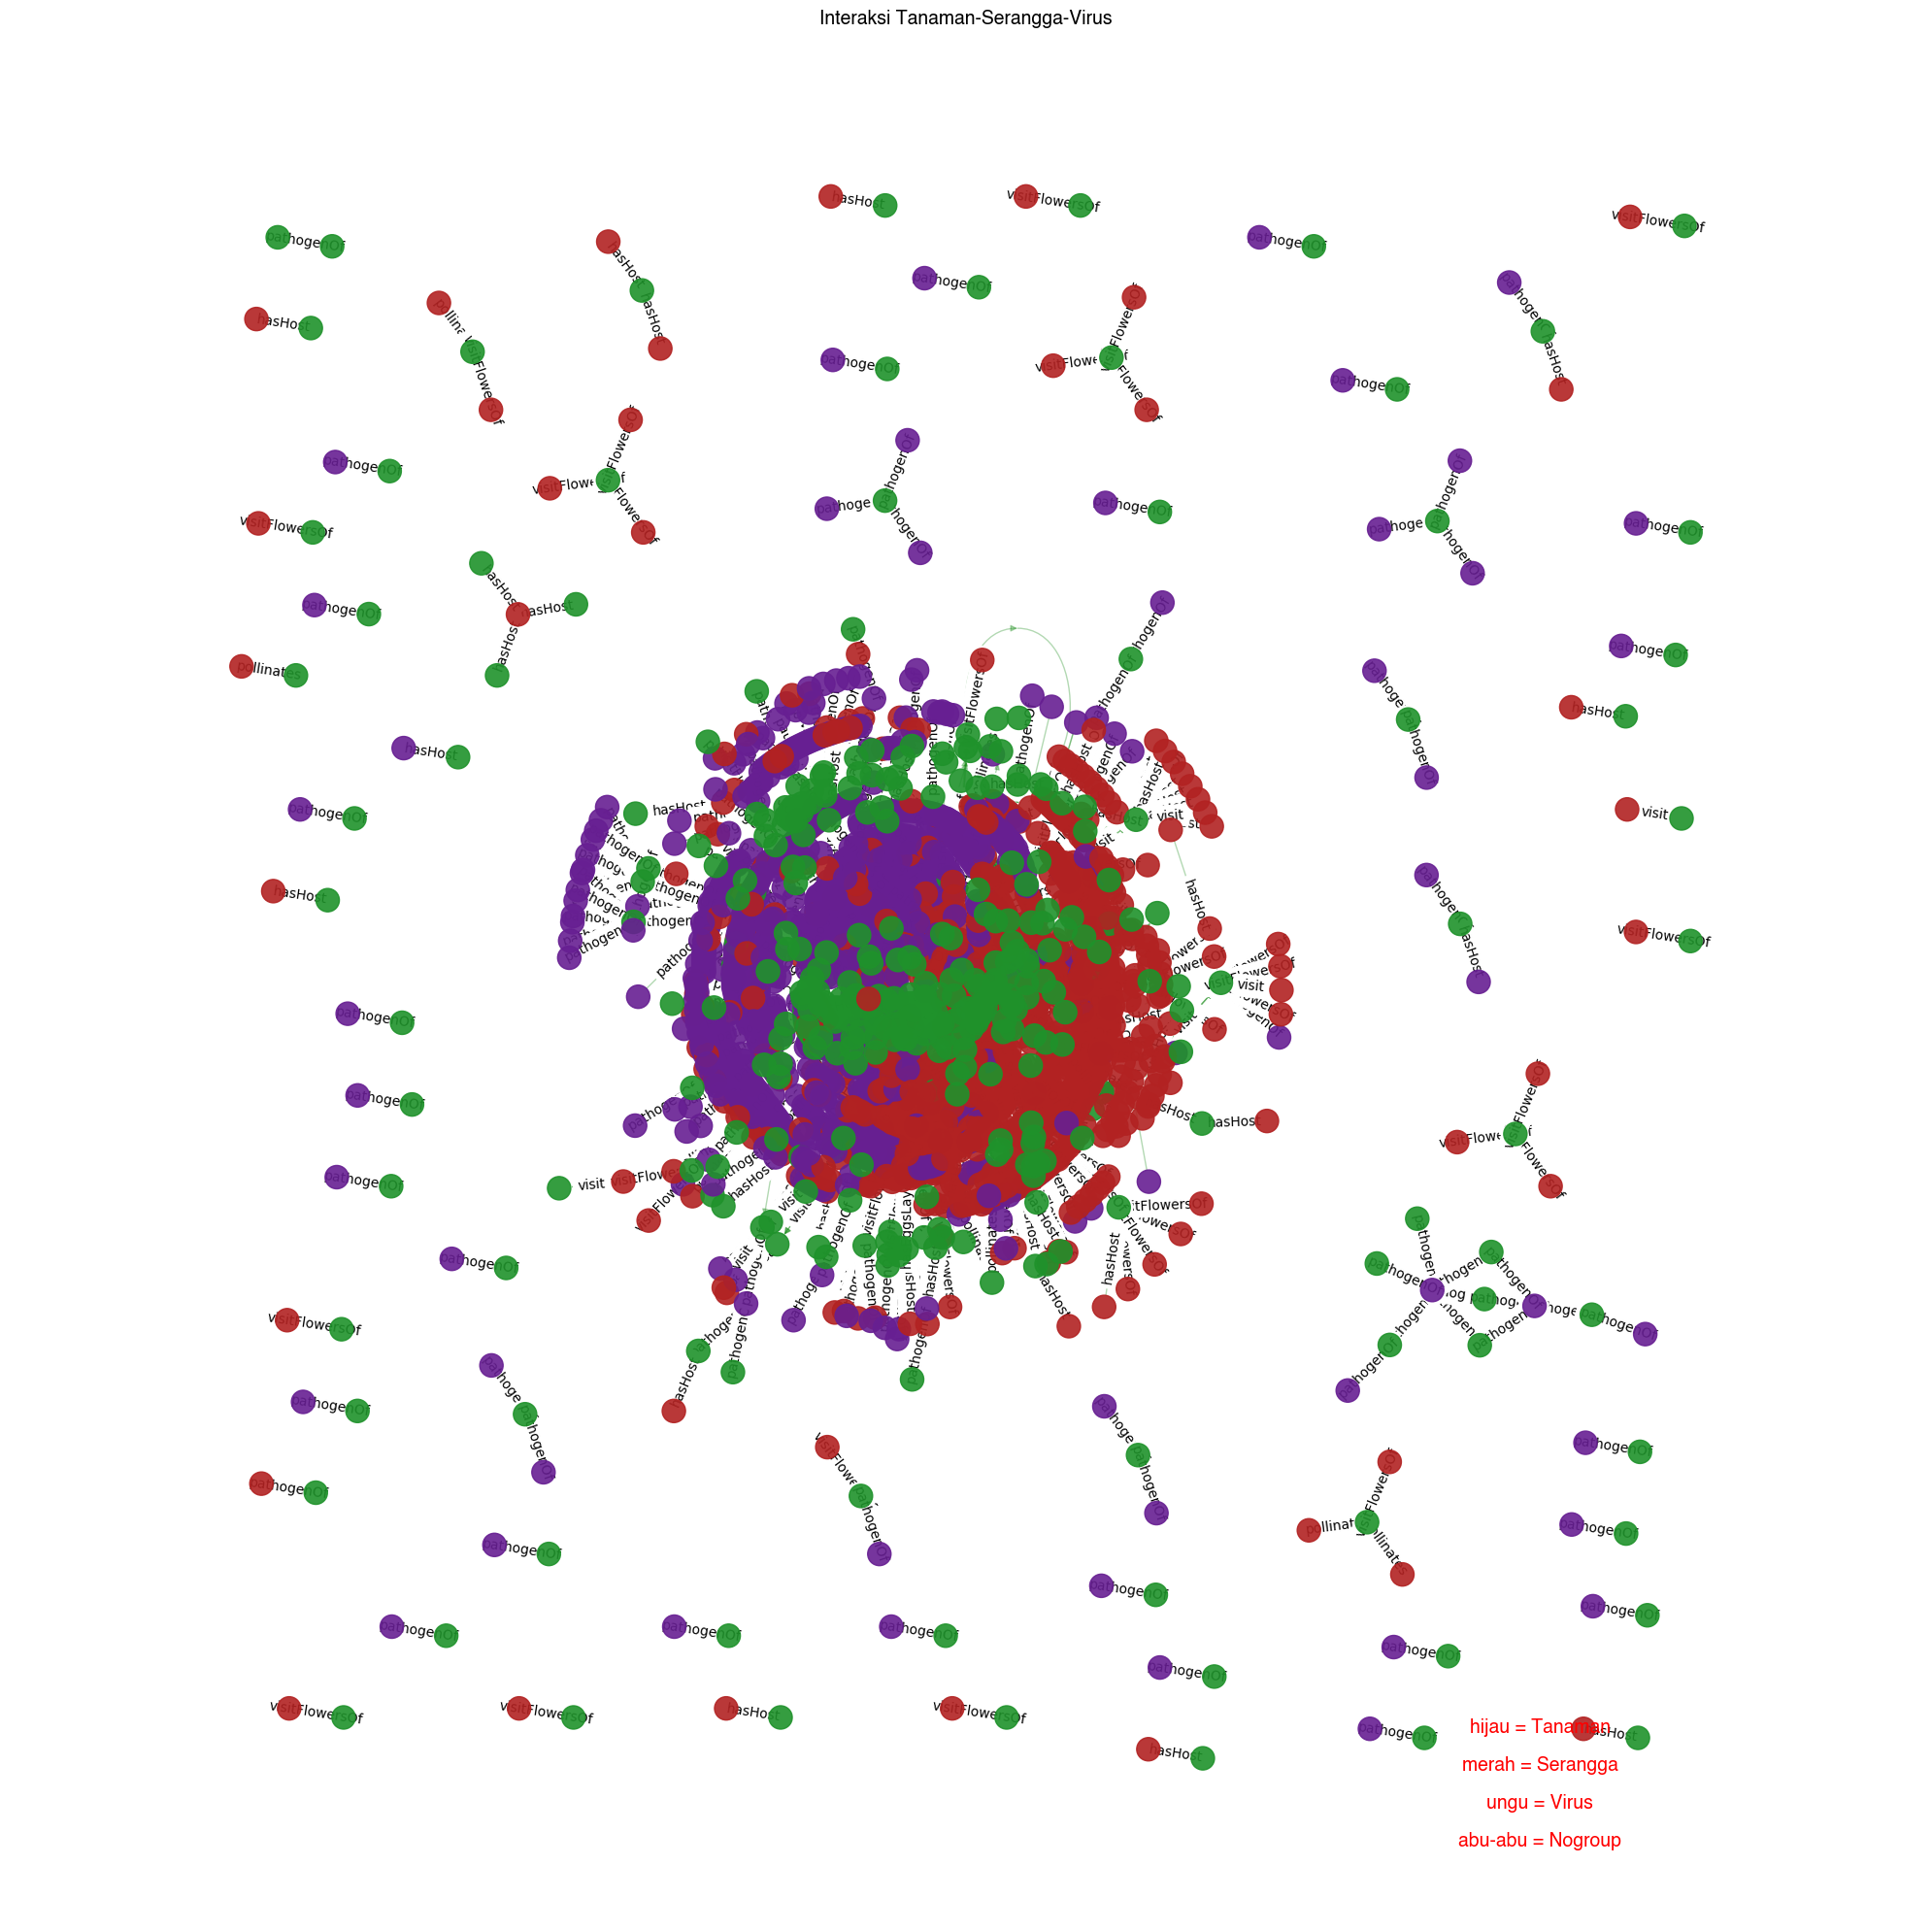

In [126]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Interaksi Tanaman-Serangga-Virus", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()